In [13]:
import pymongo
client = pymongo.MongoClient("mongodb://127.0.0.1:27017/")


In [14]:
import pandas as pd
df = pd.read_csv("course.csv")
courseData = df.to_dict(orient= "records")

df1 = pd.read_csv("student.csv")
studentData = df1.to_dict(orient= "records")

df2 = pd.read_csv("search.csv")
searchData = df2.to_dict(orient= "records")

df3 = pd.read_csv("univ.csv")
univData = df3.to_dict(orient= "records")

df4 = pd.read_csv("enrollement.csv", encoding='latin1')
enrollData = df4.to_dict(orient= "records")


C:\Users\Ghada\AppData\Local\Temp\ipykernel_10232\2527736514.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("student.csv")


In [15]:
from bson import ObjectId

client.drop_database("Mooc")    
db = client["Mooc"]

In [16]:
from bson import ObjectId, DBRef

univ_id_map = {}
univData = []
for univ in df3.to_dict(orient="records"):
    univ['_id'] = ObjectId()
    univ_id_map[univ['id']] = univ['_id']
    univ['courses'] = []
    for course in df.to_dict(orient="records"):
        if course.get('course.uni') == univ['id']:
            course['_id'] = ObjectId()
            univ['courses'].append(course)
    univData.append({
        '_id': univ['_id'],
        'uni_name': univ['uni.name'],
        'uni_country': univ['uni.country'],
        'courses': univ['courses']
    })
    

db["University"].insert_many(univData)


searches_by_user = {}
for search in searchData:
    user_id = search['search.user']
    if user_id not in searches_by_user:
        searches_by_user[user_id] = []
    search['_id'] = ObjectId()
    searches_by_user[user_id].append(search)


student_id_map = {}
for student in studentData:
    student['_id'] = ObjectId()
    student_id_map[student['id']] = student['_id']
    student_searches = searches_by_user.get(student['id'], [])
    db["Student"].insert_one({
        '_id': student['_id'],
        'userid_DI': student['id'],
        'name':student['userid_DI'],
        'Contry': student['final_cc_cname_DI'],
        'Studies': student['LoE_DI'],
        'gender': student['gender'],
        'age': student['age'],
        'searches': student_searches
    })
    


def add_object_ids(df):
    df['_id'] = [ObjectId() for _ in range(len(df))]
    return df.to_dict(orient="records")

courseData = add_object_ids(df)

course_id_map = {course['id']: course['_id'] for course in courseData}

for enrollment in enrollData:
    enrollment['_id'] = ObjectId()
    db["Enrollment"].insert_one({
        '_id': enrollment['_id'],
        'student': DBRef('Student', student_id_map[enrollment['student.id']]),
        'course': DBRef('Course', course_id_map[enrollment['course.id']]),
        'explored': enrollment['explored'],
        'comments': enrollment['comment'],
        'viewed': enrollment['viewed'],
        'certified': enrollment['certified'],
        'activeDays': enrollment['ndays_act'],
        'completed': enrollment['incomplete_flag'],
    })






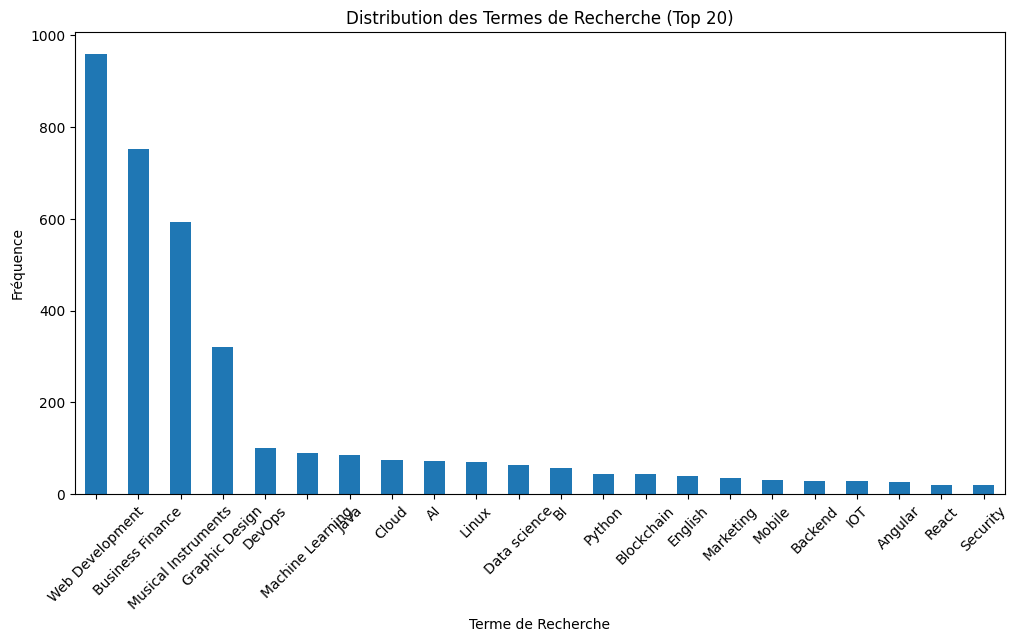

In [9]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
from bson import ObjectId, DBRef


client = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
db = client["Mooc"]


students = list(db["Student"].find({}, {'searches': 1, 'userid_DI': 1}))
search_data = []

for student in students:
    student_id = student['userid_DI']
    searches = student.get('searches', [])
    for search in searches:
        search['userid_DI'] = student_id
        search_data.append(search)


search_data = pd.DataFrame(search_data)

#print(search_data.head(20))


term_counts = search_data['search.words'].value_counts()

plt.figure(figsize=(12, 6))
term_counts.head(22).plot(kind='bar')
plt.title('Distribution des Termes de Recherche (Top 20)')
plt.xlabel('Terme de Recherche')
plt.ylabel('Fréquence')
plt.xticks(rotation=45)
plt.show()



C:\Users\Ghada\AppData\Local\Temp\ipykernel_24120\892675316.py:34: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  search_data_df['month_year'] = search_data_df['search.date'].dt.to_period('M')


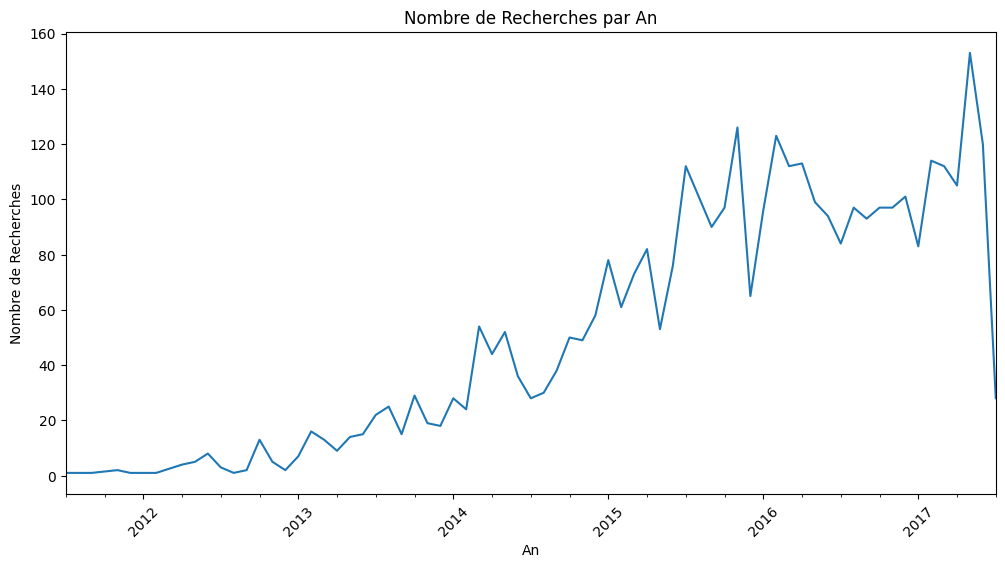

In [13]:
import pymongo
import pandas as pd
import matplotlib.pyplot as plt
from bson import ObjectId, DBRef


client = pymongo.MongoClient("mongodb://127.0.0.1:27017/")

db = client["Mooc"]

students = list(db["Student"].find({}, {'searches': 1, 'userid_DI': 1}))

search_data = []
for student in students:
    student_id = student['userid_DI']
    searches = student.get('searches', [])
    for search in searches:
        search['userid_DI'] = student_id
        search_data.append(search)


search_data_df = pd.DataFrame(search_data)


if 'search.date' in search_data_df.columns:
    search_data_df['search.date'] = pd.to_datetime(search_data_df['search.date'])
else:
    raise KeyError("La colonne 'search.date' n'existe pas dans les données de recherche.")


search_data_df['month_year'] = search_data_df['search.date'].dt.to_period('M')

monthly_search_counts = search_data_df['month_year'].value_counts().sort_index()


plt.figure(figsize=(12, 6))
monthly_search_counts.plot(kind='line')
plt.title('Nombre de Recherches par An')
plt.xlabel('An')
plt.ylabel('Nombre de Recherches')
plt.xticks(rotation=45)
plt.show()

